In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import time
import random
import os
import io
import logging
import numpy as np
import mxnet as mx
from mxnet import gluon,nd,autograd,npx
import gluonnlp as nlp
import nmt
from gluonnlp.model.transformer import ParallelTransformer, get_transformer_encoder_decoder
import pandas as pd 
nlp.utils.check_version('0.7.0')

In [2]:
np.random.seed(101)
random.seed(101)
mx.random.seed(10001)
ctx = mx.gpu(0)

# parameters for dataset
dataset = 'pubchem'
src_lang, tgt_lang = 'random_smiles', 'rdkit_canonical_smiles'
src_max_len, tgt_max_len = 100, 100

# parameters for model
num_units=128
hidden_size=1024
tf_dropout=0
epsilon=0.1
num_layers=3
num_heads=4
scaled=True
share_embed=True
embed_size=128
tie_weights=True
embed_initializer=None
magnitude = 3.0
lr_update_factor = 0.5
param_file = 'C:\\Users\\QI_LAB\\Desktop\\IL-PROPERTY-PREDICT-PUBCHEM\\smiles_transformer_128_1024\\valid_best.params'

In [3]:
def _load_vocab(file_path, **kwargs):
    with open(file_path, 'r') as f:
        return nlp.Vocab.from_json(f.read())

In [4]:
src_vocab = _load_vocab('C:\\Users\\QI_LAB\\Desktop\\IL-PROPERTY-PREDICT-PUBCHEM\\datasets\\pubchem\\vocab.random_smiles.json')
tgt_vocab = _load_vocab('C:\\Users\\QI_LAB\\Desktop\\IL-PROPERTY-PREDICT-PUBCHEM\\datasets\\pubchem\\vocab.rdkit_canonical_smiles.json')

In [5]:
encoder, decoder, one_step_ahead_decoder = get_transformer_encoder_decoder(
    units=num_units,
    hidden_size=hidden_size,
    dropout=tf_dropout,
    num_layers=num_layers,
    num_heads=num_heads,
    max_src_length=src_max_len,
    max_tgt_length=tgt_max_len,
    scaled=scaled)
model = nlp.model.translation.NMTModel(src_vocab=src_vocab,
                 tgt_vocab=tgt_vocab,
                 encoder=encoder,
                 decoder=decoder,
                 one_step_ahead_decoder=one_step_ahead_decoder,
                 embed_size=num_units,
                 embed_initializer=None,
                 prefix='transformer_')

In [6]:
#model.initialize(init=mx.init.Xavier(magnitude=magnitude), ctx=ctx)

In [7]:
model.load_parameters(param_file,ctx=ctx)

model.hybridize()

def encode(model, src_seq, src_vocab,ctx):
    src_sentence = src_vocab[src_seq.split()]
    src_sentence.append(src_vocab[src_vocab.eos_token])
    src_npy = np.array(src_sentence, dtype=np.int32)
    src_nd = mx.nd.array(src_npy)
    src_nd = src_nd.reshape((1, -1)).as_in_context(ctx)
    src_valid_length = mx.nd.array([src_nd.shape[1]]).as_in_context(ctx)
    enc_outputs = model.encode(src_nd,valid_length=src_valid_length)
    return enc_outputs

for sentence in ['c 1 ( N = C ( N ) N ) s c c ( - c 2 c c ( C ) n ( C ) c 2 ) n 1', 'C ( C ( c 1 c c c ( C ( N O ) = O ) c c 1 ) C C ) C']:
    e = encode(model, sentence,src_vocab,ctx)
    print(e)

In [8]:
from rdkit import Chem
def canonical_smile(sml):
    try:
        m = Chem.MolFromSmiles(sml)
        return Chem.MolToSmiles(m, canonical=True,isomericSmiles=False)
    except:
        return float('nan')

In [9]:
def no_split(sm):
    arr = []
    i = 0
    try:
        len(sm)
    except:
        print(sm)
    while i < len(sm)-1:
        arr.append(sm[i])
        i += 1
    if i == len(sm)-1:
        arr.append(sm[i])
    return ' '.join(arr)

In [10]:
length_clip = nlp.data.ClipSequence(100)
# Helper function to preprocess a single data point
def preprocess(data):
    # A token index or a list of token indices is
    # returned according to the vocabulary.
    src_sentence = src_vocab[data.split()]
    src_sentence.append(src_vocab[src_vocab.eos_token])
    src_npy = np.array(src_sentence, dtype=np.int32)
    src_nd = mx.nd.array(src_npy)
    return src_nd

# Helper function for getting the length
def get_length(x):
    return float(len(x.split(' ')))

In [11]:
cnn_dropout = 0.1
batch_size = 64
bucket_num, bucket_ratio = 2, 0

In [12]:
class SigmaNet(gluon.HybridBlock):
    """Network for sentiment analysis."""
    def __init__(self, dropout, src_vocab=src_vocab,embed_size=embed_size,output_size=1,
                 num_filters=(100, 200, 200, 200, 200, 100, 100, 100, 100,100), ngram_filter_sizes=(1, 2, 3,4, 5, 6, 7, 8, 9, 10),prefix=None, params=None):
        super(SigmaNet, self).__init__(prefix=prefix, params=params)
        with self.name_scope():
            self.src_embed = None
            self.encoder = None # will set with lm encoder later
            self.textcnn = nlp.model.ConvolutionalEncoder(embed_size=embed_size,
                                                          num_filters=num_filters,
                                                          ngram_filter_sizes=ngram_filter_sizes,
                                                          conv_layer_activation='relu',
                                                          num_highway=1)
            '''
            self.conv = gluon.nn.HybridSequential()
            with self.conv.name_scope():
                self.conv.add(gluon.nn.BatchNorm())
                self.conv.add(gluon.nn.Conv1D(256,kernel_size=3, padding=1,activation= 'relu'))
                self.conv.add(gluon.nn.BatchNorm())
                self.conv.add(gluon.nn.Conv1D(256,kernel_size=3, padding=1,activation= 'relu'))
            self.resnet = gluon.nn.HybridSequential()
            with self.resnet.name_scope():
                self.resnet.add(resnet_block(256, 2, first_block=True),
                resnet_block(256, 2),
                resnet_block(256, 2),
                resnet_block(256, 2),gluon.nn.GlobalAvgPool1D())
            '''
            self.output = gluon.nn.HybridSequential()
            with self.output.name_scope():
                #self.output.add(gluon.nn.Dense(1024))
                #self.output.add(gluon.nn.Dropout(dropout))
                self.output.add(gluon.nn.Dense(512))
                #self.output.add(gluon.nn.Dropout(dropout))
                self.output.add(gluon.nn.Dense(output_size, flatten= False))

    def hybrid_forward(self, F, src_nd, valid_length):# pylint: disable=arguments-differ
        #src_nd = F.reshape(src_nd, (F.shape_array(src_nd), -1))
        src_embed_ = self.src_embed(src_nd)
        encoded,_ = self.encoder(src_embed_,valid_length=valid_length)  # Shape(T, N, C)
        #encoded = F.reshape(encoded,shape= (F.shape_array(encoded)[1],batch_size,-1))
        textcnn = self.textcnn(F.transpose(encoded,axes = (1,0,2)))
        #transformed = self.resnet(mx.symbol.expand_dims(textcnn,axis=1))
        #conv = self.conv(F.transpose(mx.symbol.expand_dims(textcnn,axis=1),axes = (0,2,1)))
        #conv = self.conv(mx.symbol.expand_dims(textcnn,axis=1))
        #transformed = self.resnet(conv)
        out = self.output(textcnn)
        return out

In [13]:
net = SigmaNet(dropout=cnn_dropout)
net.encoder = model.encoder
net.src_embed =  model.src_embed
net.hybridize()
print(net)
#net.textcnn.initialize(mx.init.Xavier(), ctx=ctx)
#net.output.initialize(mx.init.Xavier(), ctx=ctx)

SigmaNet(
  (src_embed): HybridSequential(
    (0): Embedding(72 -> 128, float32)
    (1): Dropout(p = 0.0, axes=())
  )
  (encoder): TransformerEncoder(
    (layer_norm): LayerNorm(eps=1e-05, axis=-1, center=True, scale=True, in_channels=128)
    (transformer_cells): HybridSequential(
      (0): TransformerEncoderCell(
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0, axes=())
          )
          (proj_query): Dense(128 -> 128, linear)
          (proj_key): Dense(128 -> 128, linear)
          (proj_value): Dense(128 -> 128, linear)
        )
        (proj): Dense(128 -> 128, linear)
        (ffn): PositionwiseFFN(
          (ffn_1): Dense(128 -> 1024, linear)
          (activation): Activation(relu)
          (ffn_2): Dense(1024 -> 128, linear)
          (layer_norm): LayerNorm(eps=1e-05, axis=-1, center=True, scale=True, in_channels=128)
        )
        (layer_norm): LayerNorm(eps=1e-05,

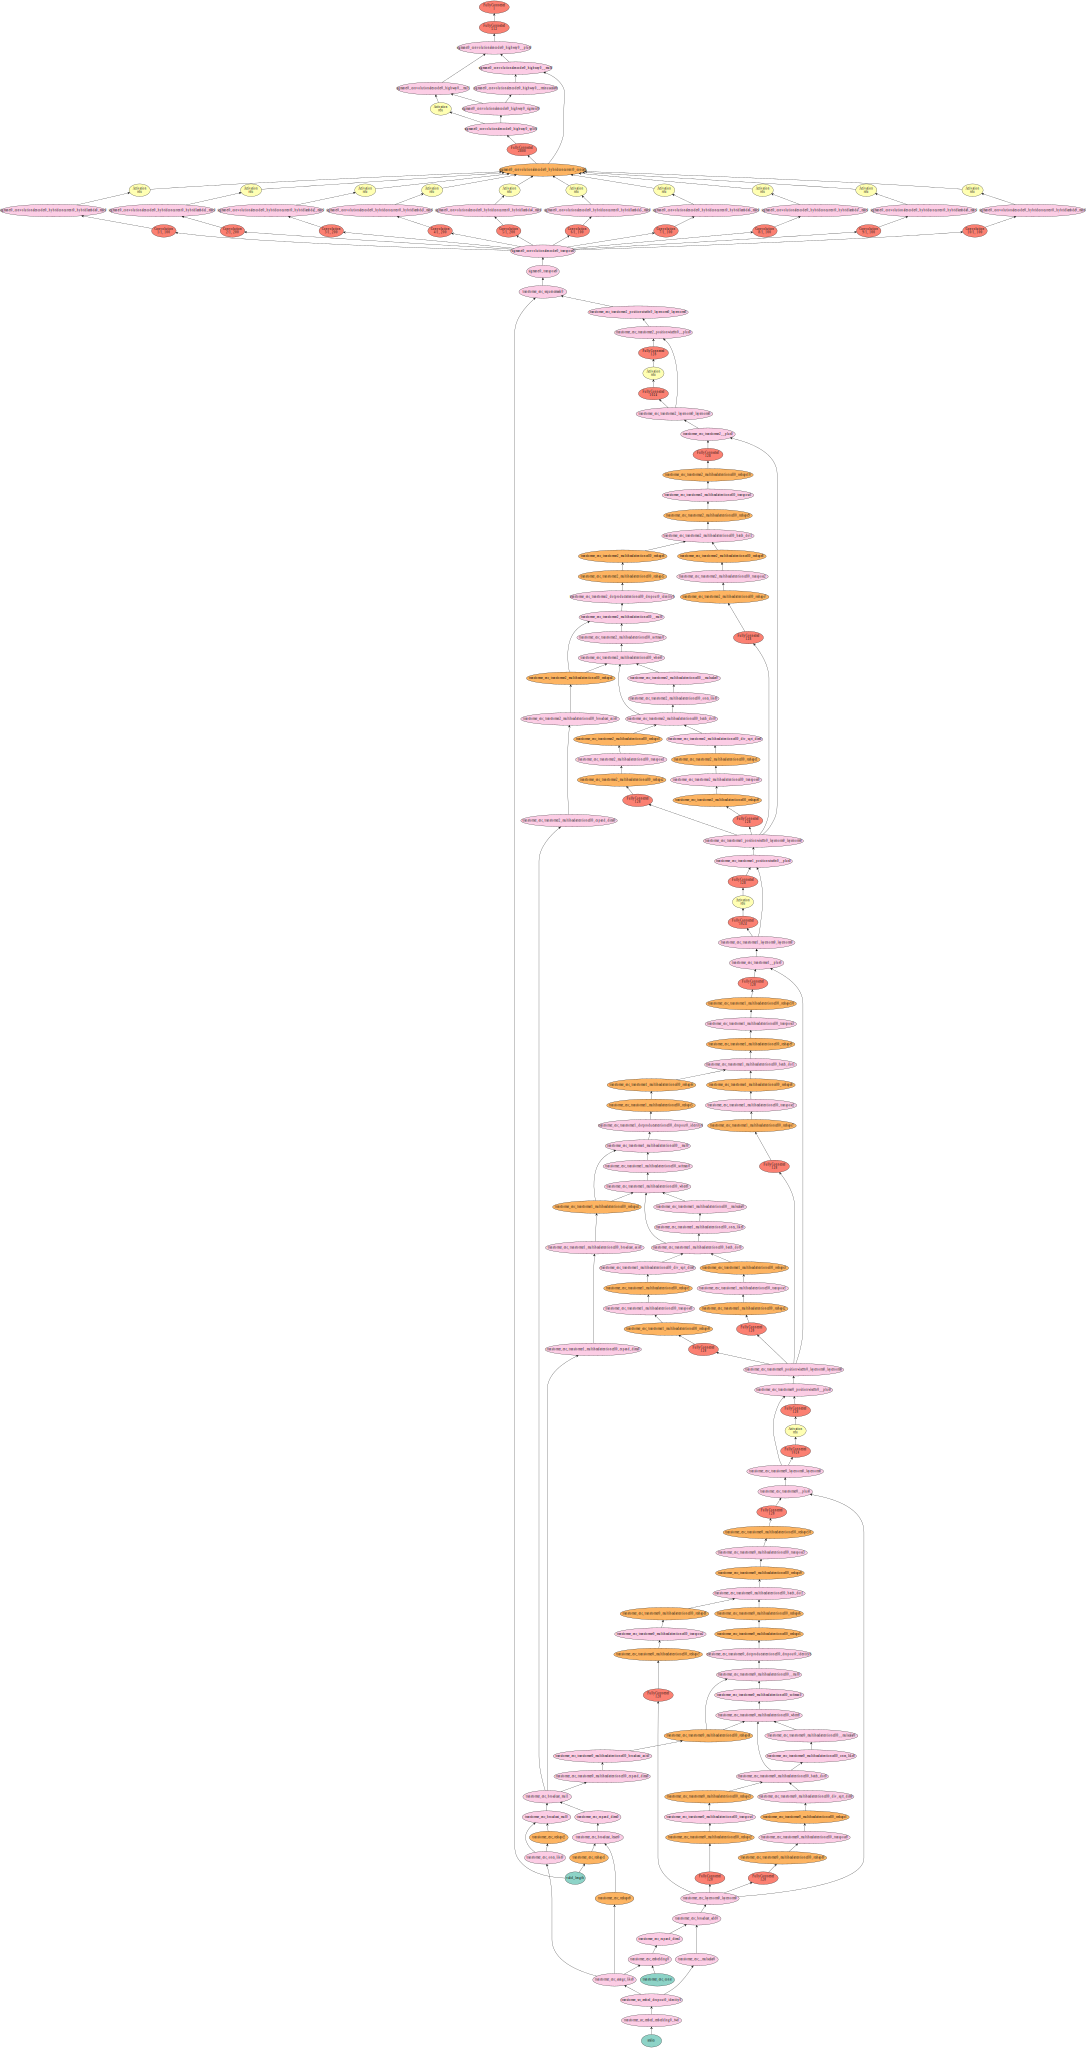

In [14]:
mx.viz.plot_network(net(mx.sym.var('smiles'),mx.sym.var('valid_length')),
                    node_attrs={
                        "shape": "oval",
                        "fixedsize": "false"
                    })

In [15]:
from sklearn import metrics

def get_r2(label, pred, multioutput='uniform_average'):
    label = label.asnumpy()
    pred = pred.asnumpy()
    r2 = metrics.r2_score(label,pred,multioutput=multioutput)
    return r2

In [16]:
home_dir = 'C:\\Users\\QI_LAB\\Desktop\\IL-PROPERTY-PREDICT-PUBCHEM\\MP'
save_dir = os.path.join(home_dir,'textcnn')
from sklearn.metrics import mean_squared_error
def train(net, train_data, batch_size, learning_rate, context, epochs,log_interval=10, dev_data=None, fold=None ):
    start_pipeline_time = time.time()
    net.textcnn.initialize(mx.init.Xavier(), ctx=context, force_reinit=True)
    #net.conv.initialize(mx.init.Xavier(), ctx=context, force_reinit=True)
    #net.resnet.initialize(mx.init.Xavier(), ctx=context, force_reinit=True)
    net.output.initialize(mx.init.Xavier(), ctx=context, force_reinit=True)
    num_epoch_lr = 10
    factor = 0.5
    schedule = mx.lr_scheduler.FactorScheduler(base_lr = learning_rate, step=len(train_data)* num_epoch_lr,factor=factor)
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'lr_scheduler': schedule})
    #trainer = gluon.Trainer(net.collect_params(), 'adam',{'learning_rate': learning_rate})
    loss = gluon.loss.L1Loss()
    # Training/Testing.
    best_epoch_L = 100
    for epoch in range(epochs):
        # Epoch training stats.
        start_epoch_time = time.time()
        epoch_L = 0.0
        epoch_r2 = 0.0
        epoch_sent_num = 0
        r2_num = 0
        epoch_wc = 0
        # Log interval training stats.
        start_log_interval_time = time.time()
        log_interval_wc = 0
        log_interval_sent_num = 0
        log_interval_L = 0.0
        for i, ((data, length), label) in enumerate(train_data):
            data = data.as_in_context(context)
            length = length.as_in_context(context).astype(np.float32)
            label = label.as_in_context(context)
            wc = max_len
            log_interval_wc += wc
            epoch_wc += wc
            log_interval_sent_num += label.shape[0]
            epoch_sent_num += label.shape[0]
            with autograd.record():
                output = net(data,length)
                L = loss(output, label).sum()
                #print('output:',output)
                #print('label:',label)
                #print('loss:',loss(output, label))
                #print('mse:',mean_squared_error(output.asnumpy(), label.asnumpy(), multioutput='raw_values'))
                r2 = get_r2(output,label)
            L.backward()
            # Update parameter.
            trainer.step(batch_size)
            log_interval_L += L.asscalar()
            epoch_L += L.asscalar()
            epoch_r2+=r2
            r2_num+=1
            if (i + 1) % log_interval == 0:
                print('[Epoch %d Batch %d/%d] avg loss %g, throughput %gK wps' % (
                    epoch, i + 1, len(train_data),
                    log_interval_L / log_interval_sent_num,
                    log_interval_wc / 1000 / (time.time() - start_log_interval_time)))
                # Clear log interval training stats.
                start_log_interval_time = time.time()
                log_interval_wc = 0
                log_interval_sent_num = 0
                log_interval_L = 0
        end_epoch_time = time.time()
        
        if  (epoch_L/ epoch_sent_num) < best_epoch_L:
            best_epoch_L = epoch_L
            save_path = os.path.join(save_dir, 'MP_best.params')
            net.save_parameters(save_path)
         
        
        print('[Epoch %d] train avg loss %g, train avg r2 %g,'
              'throughput %gK wps' % (
                  epoch, epoch_L / epoch_sent_num, epoch_r2 / r2_num,
                  epoch_wc / 1000 / (end_epoch_time - start_epoch_time)))
        print('learning rate:',trainer.learning_rate)
        '''
        if epoch + 1 >= (epochs * 2) // 3:
            new_lr = trainer.learning_rate * lr_update_factor
            trainer.set_learning_rate(new_lr)
        '''
    print('Total time cost %.2fs'%(time.time()-start_pipeline_time))
    return epoch_L / epoch_sent_num, epoch_r2 / r2_num

In [17]:
def get_dataloader(train_dataset,train_smiles_lengths):

    # Pad data, stack label and lengths
    batchify_fn = nlp.data.batchify.Tuple(
        nlp.data.batchify.Pad(axis=0, pad_val=0, ret_length=True),
        nlp.data.batchify.Stack(dtype='float32'))
    train_batch_sampler = nlp.data.sampler.FixedBucketSampler(
        train_smiles_lengths,
        batch_size=batch_size,
        num_buckets=bucket_num,
        ratio=bucket_ratio,
        shuffle=True)

    # Construct a DataLoader object for both the training and test data
    train_dataloader = gluon.data.DataLoader(dataset=train_dataset,
                                             batch_sampler=train_batch_sampler,
                                             batchify_fn=batchify_fn)
    return train_dataloader

In [18]:
MP_database = pd.read_excel('melting point.xlsx',sheet_name='Sheet1')

In [19]:

train_smiles = MP_database['IL SMILES'].map(canonical_smile).map(no_split).map(preprocess)

train_smiles_lengths = MP_database['IL SMILES'].map(canonical_smile).map(no_split).map(get_length)

train_MP =mx.nd.array(MP_database['MP_K'])
train_dataset = gluon.data.SimpleDataset(gluon.data.ArrayDataset(train_smiles,train_MP))

train_dataloader = get_dataloader(train_dataset,train_smiles_lengths)

In [20]:
epochs, learning_rate = 150,0.001                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
max_len = 100
train(net, train_dataloader, batch_size, learning_rate, ctx, epochs)

[Epoch 0 Batch 10/35] avg loss 315.07, throughput 0.14043K wps
[Epoch 0 Batch 20/35] avg loss 130.36, throughput 0.0917263K wps
[Epoch 0 Batch 30/35] avg loss 81.087, throughput 0.1287K wps
[Epoch 0] train avg loss 159.543, train avg r2 -4.454e+06,throughput 0.135281K wps
learning rate: 0.001
[Epoch 1 Batch 10/35] avg loss 53.9202, throughput 6.62246K wps
[Epoch 1 Batch 20/35] avg loss 44.6057, throughput 0.304044K wps
[Epoch 1 Batch 30/35] avg loss 39.619, throughput 0.901714K wps
[Epoch 1] train avg loss 44.7223, train avg r2 -0.302917,throughput 0.265071K wps
learning rate: 0.001
[Epoch 2 Batch 10/35] avg loss 35.8869, throughput 0.305437K wps
[Epoch 2 Batch 20/35] avg loss 39.9692, throughput 0.900092K wps
[Epoch 2 Batch 30/35] avg loss 36.1023, throughput 5.68183K wps
[Epoch 2] train avg loss 37.16, train avg r2 0.284677,throughput 0.753174K wps
learning rate: 0.001
[Epoch 3 Batch 10/35] avg loss 32.1008, throughput 0.251572K wps
[Epoch 3 Batch 20/35] avg loss 33.5418, throughput 

NameError: name 'val_avg_L' is not defined

K-fold cross valid avg train loss 1.3489668809973936
K-fold cross valid avg train r2 0.9973347734852677
K-fold cross valid avg test loss 13.18546958523049
K-fold cross valid avg test r2 0.8633920641584876

Total time cost 226.34s
K-fold cross valid avg train loss 1.0208112936765557
K-fold cross valid avg train r2 0.9973985693900078
K-fold cross valid avg test loss 11.410513927679215
K-fold cross valid avg test r2 0.9079264533881546